In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import lightkurve as lk
# import astropy.units as u
# %matplotlib widget



# def lcPlots(fName):
#     """
#     Uses LightKurve to make LC plots from just a filename of a csv with flux and Time cols.
#     """
#     data = pd.read_csv(fName)
#     fluxes = data["flux"]
#     times = data["Time"]

#     fluxErrs = np.ones_like(fluxes)*1e-4 #lk needs errors

#     lc =lk.LightCurve(data=None, time=times, flux=fluxes, flux_err=fluxErrs)
#     lc = lc.normalize()
#     lc.scatter()
#     pg = lc.to_periodogram()

#     pg.plot(scale="log")
#     period = pg.period_at_max_power
#     print(period)
#     lc.fold(period).scatter()

#     lcModel = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
#     ax = lc.plot()
#     lcModel.plot(ax=ax, lw=3, ls='--',c='red')
#     return lcModel


# objName = "1999 JE82"


# fName = f"./{objName}Matches.csv"
# lcm = lcPlots(fName=fName)



In [2]:
# lcm.plot()
# vars(lcm)


(226,)
(206,)
(186,)
(166,)
(146,)
(136,)
0.27316201384103006
1.8925467315290678e-05 1 / s
[0.27316201384103006, 0.08319250252857004, 0.07841751943520708, 0.07442521527772501, 0.07431438411499589]
[1.8925467315290678e-05, 4.82294167067085e-05, 0.0001105003091634714, 0.0002228321151639064, 3.113544622838144e-05]


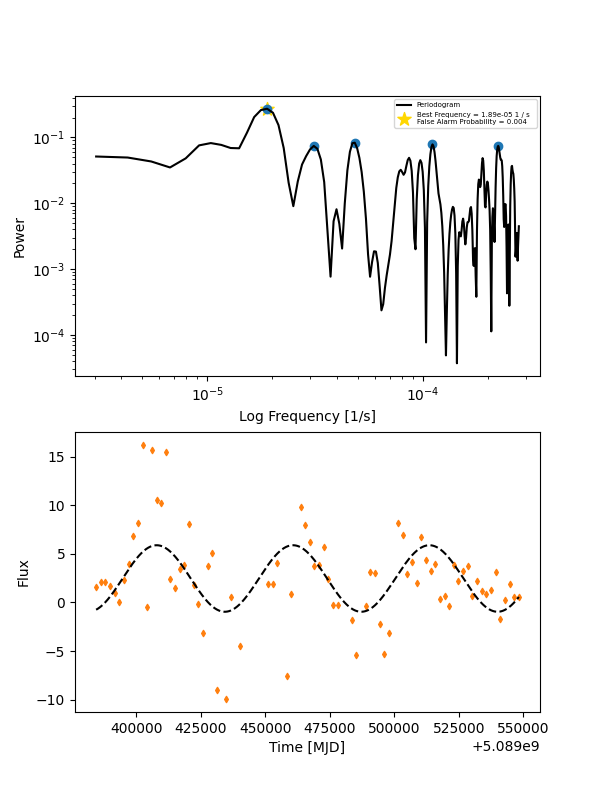

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib widget
from astropy.timeseries import LombScargle as lsp
import nifty_ls



sector = 22

#12hr queries constant
if sector <27: 
    nyquistP = 1*60*60*u.s #1/2hr ffi, so 1hr nyqist
elif sector>=27 and sector<56:
    nyquistP = 20*60*u.s #1/6hr (10 min) ffi
else: 
    nyquistP = 400*u.s   # 200 s ffi

objName = "2000 JA66"

fName = f"./{objName}LC.csv"
data = pd.read_csv(fName)

fluxes = data["COM Flux"]
times = (data["MJD"].values*u.day).to(u.s)

meanFlux = np.mean(fluxes)

centredFlux = fluxes - meanFlux
minFreq = 1/((2*(times.max()-times.min())).to(u.s)) 

# minFreq = 1e-5/u.s

# # minFreq = 1/(1468800*u.s)

maxFreq = 1/nyquistP

lsper = lsp(times, centredFlux)





freqs, powers = lsper.autopower(minimum_frequency=minFreq, maximum_frequency=maxFreq, method="fastnifty")



combedPows = powers
print(combedPows.shape)
combedFreqs = freqs
maxes = []
maxesFreqs = []

removePoints = 10

for i in range(5):
    maxes.append(np.max(combedPows).value)
    amax = np.argmax(combedPows)

    maxesFreqs.append(combedFreqs[amax].value)

    if amax >= removePoints:
        combedPows = np.delete(combedPows, np.s_[amax-removePoints:amax+removePoints])
        combedFreqs = np.delete(combedFreqs, np.s_[amax-removePoints:amax+removePoints])
    else:
        combedPows = combedPows[removePoints:]
        combedFreqs = combedFreqs[removePoints:]
    print(combedPows.shape)









bestPow = np.max(powers)
bestFreq = freqs[np.argmax(powers)]
t_fit=np.linspace(times.min(),times.max(),1000)
y_fit = lsper.model(t_fit, bestFreq) +meanFlux

f_a_prob = lsper.false_alarm_probability(np.max(powers))

modelParams = lsper.model_parameters(bestFreq)

fig, ax = plt.subplots(2, figsize = (6,8))

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Log Frequency [1/s]", ylabel="Power")
ax[0].plot(freqs, powers, c="k", label="Periodogram")


print(bestPow)
print(bestFreq)

ax[0].scatter(bestFreq,bestPow, c="gold",marker="*", s=100, label=f"Best Frequency = {bestFreq.round(7)}  \nFalse Alarm Probability = {f_a_prob.round(3)}")



ax[0].legend(fontsize=5)


print(maxes)
print(maxesFreqs)

ax[0].scatter(maxesFreqs, maxes)


ax[1].set(xlabel="Time [MJD]", ylabel="Flux")
ax[1].scatter(times, fluxes, label = "Light curve", c="tab:orange", marker = "d", s=10)
ax[1].plot(t_fit,y_fit, ls="--", c="k", label="Model")







11.232378081227957
3.881054310487757
3.674118439383968
3.026464654087018
3.127073250190364
[ 1.86586709 -0.77595228  2.49727747]


array([0.73382178, 0.38437145, 0.51505333])

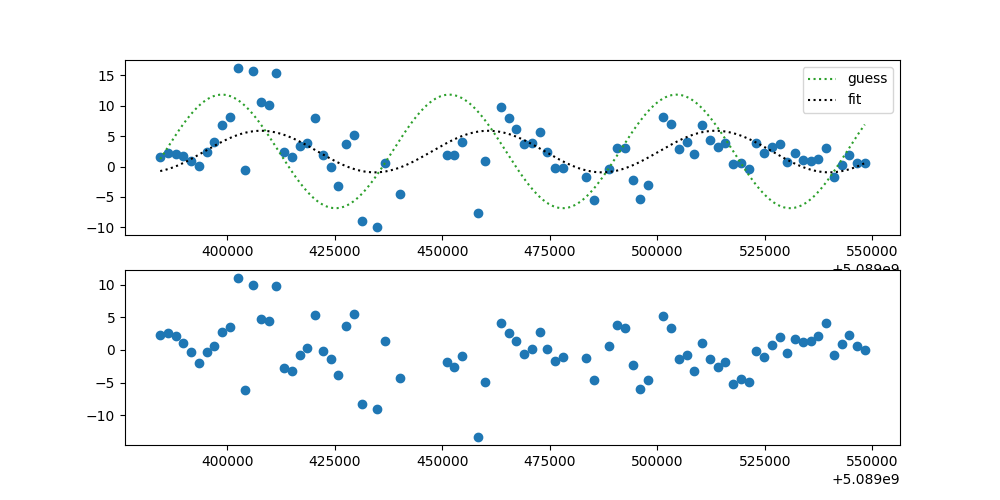

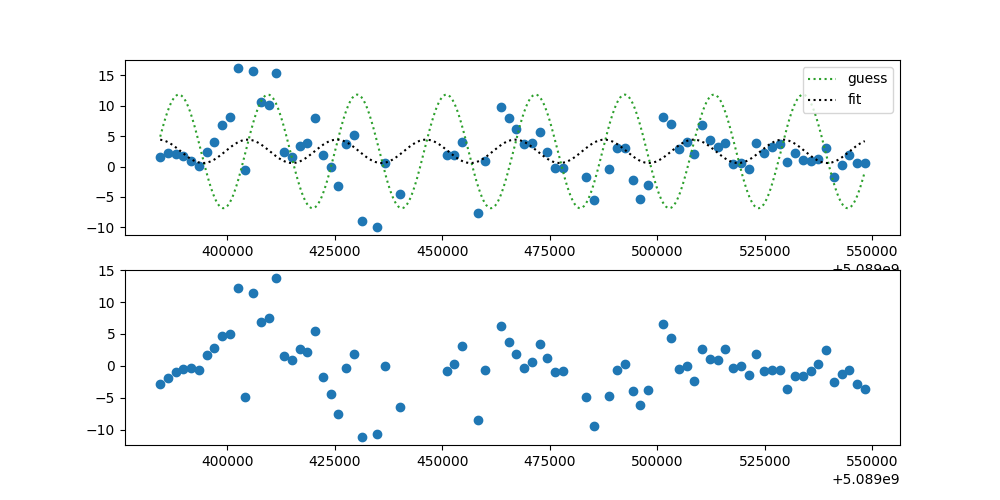

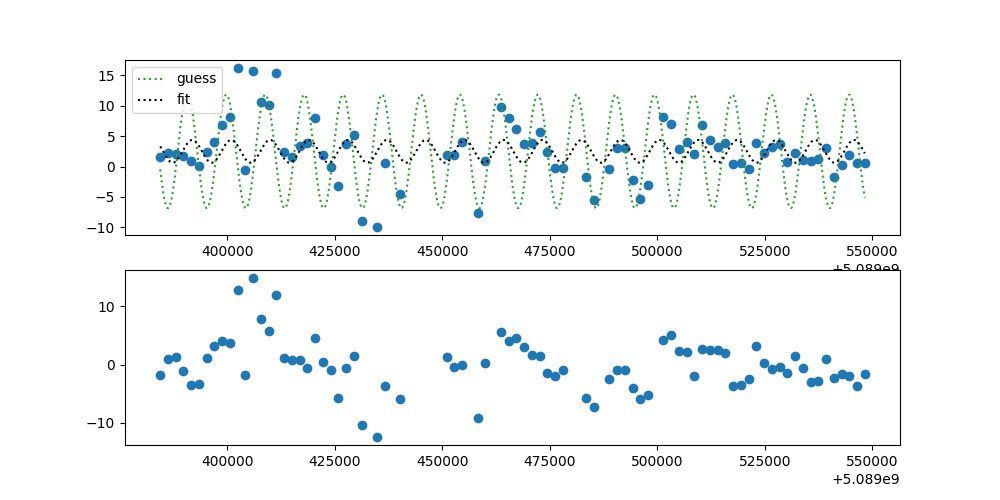

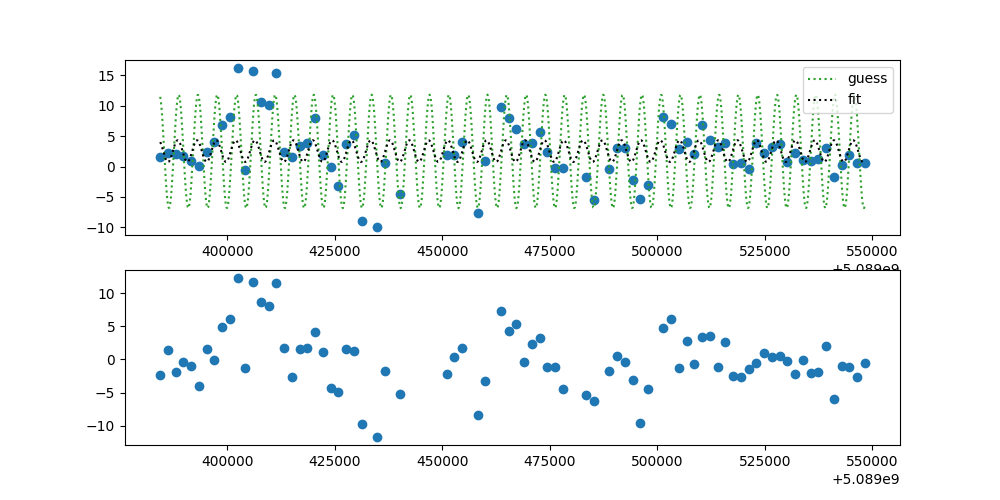

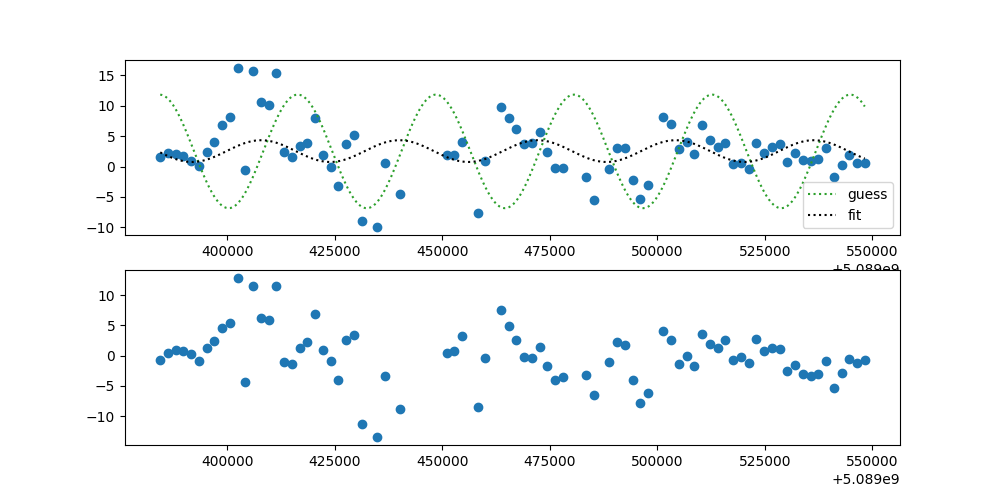

In [4]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

def sineFunc(t,freq,amp,phi, constVal):
    return amp*np.sin(2*np.pi*(freq*t)+phi) +constVal


def fitSine(ts, ys, freq, guessParams):

    fig, ax = plt.subplots(2,figsize=(10,5))

    ax[0].scatter(ts,ys)

    plotts = np.linspace(ts.min(), ts.max(),1000)

    ax[0].plot(plotts, sineFunc(plotts,freq,*guessParams), c="tab:green", ls=":", label="guess")

    lamSine = lambda t, amp, phi, conVal: sineFunc(t, freq, amp, phi, conVal)

    popt, pcov =scipy.optimize.curve_fit(lamSine, ts, ys, p0=guessParams)

    # print(f"Guess Freq = {guessParams[0]:.3e}, Fit Freq = {popt[0]:.3e}\n with uncertainty {np.sqrt(np.diag(pcov))[0]:.3e} and the condition mat is {np.linalg.cond(pcov):.3e}")
    print(f"{np.linalg.cond(pcov)}")
    ax[0].plot(plotts, sineFunc(plotts,freq,*popt), c="k", ls=":", label="fit")

    ax[0].legend()

    ax[1].scatter(ts, ys-sineFunc(ts,freq,*popt))
    

    return popt, pcov



guessSTD = np.std(fluxes)
optParas = []
covmats = []


for freq in maxesFreqs:
    gPara = [2*guessSTD,0,np.mean(fluxes)]
    optPara, covmat = fitSine((times/u.s).value, fluxes,freq, gPara)
    optParas.append(optPara)
    covmats.append(covmat)






print(optParas[2])
np.sqrt(np.diag(covmats[2]))


In [6]:
lcdbDAT = pd.read_csv("F-D_BASIC.TXT",sep='\t',skiprows=4)#.drop(index=0, inplace=True)


lcdbDAT.drop(index=0, inplace=True)

print(len(lcdbDAT.index))

ind = 8998


# print(lcdbDAT.loc[[ind]].values[0][0][7:20].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][58:65].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][90:103].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][74:83].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][127:132].strip())


valList = []

for i in lcdbDAT.index:
    name = lcdbDAT.loc[[i]].values[0][0][7:20].strip() 
    hMag = float(lcdbDAT.loc[[i]].values[0][0][58:65])
    period = float(lcdbDAT.loc[[i]].values[0][0][90:100])
    uClass = lcdbDAT.loc[[i]].values[0][0][127:132].strip()
    diam = float(lcdbDAT.loc[[i]].values[0][0][74:83])
    valList.append([name, hMag, period, uClass, diam])

lcdbDf = pd.DataFrame(valList, columns=["Name","H","Period [Hours]","U", "Diameter"])

lcdbDf.to_csv("lcdbUseful.csv", sep=",")




8998


In [7]:
import pds4_tools

mainBeltWise = pds4_tools.read("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml")

# mbWiseXML = pd.read_xml("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml")

mainBeltWise.info()


Processing label: ./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml
Now processing a Table_Delimited structure: TABLE
0   Table_Delimited  'TABLE'  22 fields x 178883 records


In [6]:
# pds4_tools.view("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml")

In [8]:
mainBeltWise = pd.read_csv("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.csv", usecols=(0,1,11),header=None)
mainBeltWise.rename(columns = {0:"Number",1:"Name", 11:"Diameter"}, inplace=True)

def _name_cut(df, name:str, colName:str="Name"):
    "take a df and gives  only the values where the colName == name"
    toReturn = df.loc[df.index[df[colName]==name]]
    toReturn.reset_index(drop=True, inplace=True)
    return toReturn

for i, name in enumerate(lcdbDf["Name"]):
    nCut = _name_cut(mainBeltWise, name) 
    # print(name)
    try:
        wiseDiam = float(np.round(nCut["Diameter"].values,2))
        lcdbDiam = float(np.round(lcdbDf.at[i,"Diameter"].values,2))
    except Exception as e:
        print(e)
        print(nCut)
        break
        continue

    if  wiseDiam!=lcdbDiam :
        print(f"{name} has different diameters WISE:{wiseDiam} and LCDB{lcdbDiam}")


only length-1 arrays can be converted to Python scalars
Empty DataFrame
Columns: [Number, Name, Diameter]
Index: []


/tmp/ipykernel_6109/1706930139.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers
/tmp/ipykernel_6109/1706930139.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers


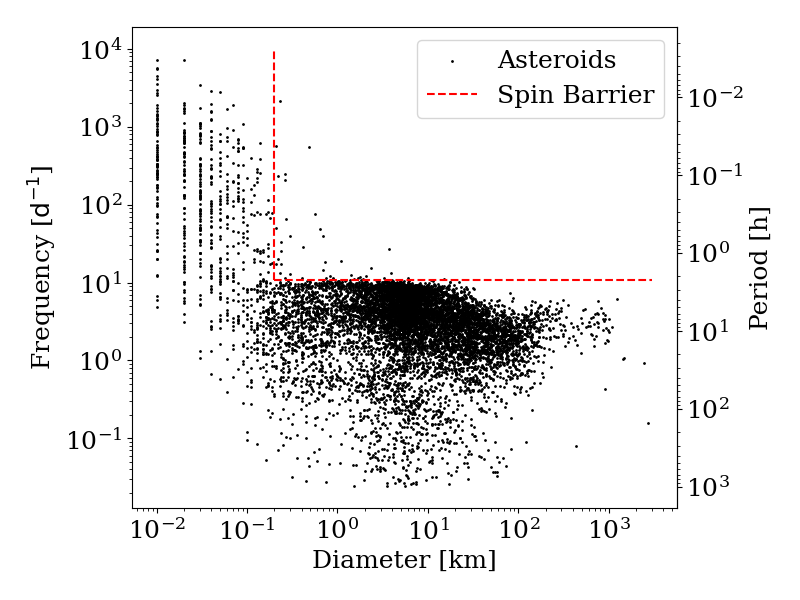

/tmp/ipykernel_6109/1706930139.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers


In [30]:
plt.rcParams.update({
    "font.size": 18,
    "font.family": "serif",
    "figure.autolayout": True,
    "axes.grid": False,
    "xtick.minor.visible": False,
    # "ytick.minor.visible": True,
})


fig5, ax5= plt.subplots(figsize=(8,6))

ax5.set(xscale="log", yscale="log", xlabel=f"Diameter [km]", ylabel="Frequency [$\mathrm{d}^{-1}$]")

ax5.scatter(lcdbDf["Diameter"], 24/lcdbDf["Period [Hours]"], s=1,c="k", label="Asteroids")

def perToFreq(pers):
    "assume pers in hrs, out in /d"
    return 24/pers

def freqToPer(freqs):
    "assume freqs in /d, out in hrs"
    return 24/freqs



ax6 = ax5.secondary_yaxis("right", functions=(freqToPer, perToFreq))
ax6.set_ylabel("Period [h]")


freqLim = 24/2.2
diamLim = 0.2

ax5.hlines(freqLim, diamLim,3000, ls="--", colors="r", label="Spin Barrier")
ax5.vlines(diamLim,freqLim,1e4, ls="--", colors="r")

ax5.legend()


fig5.savefig(f"./Testing Figures/Diam-FreqPlot.pdf")


In [10]:
bernoulliMPC = pd.read_csv("./bernoulli.txt")
from astropy.time import Time
from datetime import datetime
vals=[]
otherMagSystems = [] 


for i in bernoulliMPC.index:
    if bernoulliMPC.loc[[i]].values[0][0][15:19]=='2020':
        if bernoulliMPC.loc[[i]].values[0][0][20:22] == '02':
            day = int(round(float(bernoulliMPC.loc[[i]].values[0][0][23:28]),0))
            if day >=19 and day <=25:
                mag = bernoulliMPC.loc[[i]].values[0][0][65:71]
                try: 
                    int(mag) #should be a filter identified. A whole bunch of RA and Dec are too long and then don't even have a mag, so if it can be an int, it is not a mag
                    continue
                except:
                    
                    
                    date = bernoulliMPC.loc[[i]].values[0][0][15:28]

                    date = date.replace(" ", "-")

                    splitdate = date.split(".")
                    afterPoint = float(f"0.{splitdate[1]}")
                    hrs = afterPoint*24
                    mins = (hrs-int(hrs))*60
                    if hrs <10:
                        if mins <10:
                            date = f"{splitdate[0]} 0{int(hrs)}:0{int(mins)}"
                        else:
                            date = f"{splitdate[0]} 0{int(hrs)}:{int(mins)}"
                    elif mins <10:
                            date = f"{splitdate[0]} {int(hrs)}:0{int(mins)}"
                    else:
                            date = f"{splitdate[0]} {int(hrs)}:{int(mins)}"
                    if mag[-1] == "G":
                        vals.append([ round(Time(date).mjd,4), float(mag[:-1])])
                    else:
                        otherMagSystems.append([round(Time(date).mjd,4),mag])

inTimeDf = pd.DataFrame(vals, columns=["Date","Mag"])


print(np.unique(inTimeDf["Mag"]))

inTimeDf.to_csv("./MPC_Bernoulli_mags.csv", sep=",")


[14.7 14.8 14.9 15. ]


[20.46505 20.4758 ]
[0.08121896 0.05568096]
20.472749999999998
0.06963463378393088
20.401--20.651
0.24990000000000023
0.15549999999999997
1.6070739549839246


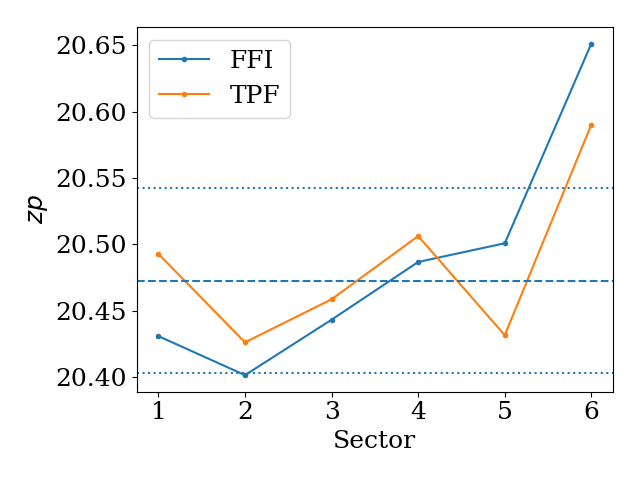

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib widget

if __name__ == '__main__':
	# Zeropoints:
	zp = np.array([
		[1, 20.4309, 20.4929],
		[2, 20.4015, 20.4262],
		[3, 20.4433, 20.4587],
		[4, 20.4868, 20.5063],
		[5, 20.5009, 20.4316],
		[6, 20.6514, 20.5903],
	])

	sector = zp[:,0]

	m = np.median(zp[:, 1:], axis=0)
	s = np.std(zp[:, 1:], axis=0)
	print( m )
	print( s )

	m2 = np.median(zp[:, 1:])
	s2 = np.std(zp[:, 1:])
	print(m2)
	print(s2)

	low = np.min(zp[:, 1:])
	high = np.max(zp[:, 1:])

	print('{0:.3f}--{1:.3f}'.format(low, high))
	range1 = high - low
	range2 = 20.4735 - 20.318
	print(range1)
	print(range2)
	print(range1 / range2)

	fig, ax = plt.subplots()
	ax.plot(sector, zp[:,1], '.-', label='FFI')
	#plt.fill_between([sector[0], sector[-1]], [m[0]+s[0], m[0]+s[0]], [m[0]-s[0], m[0]-s[0]], alpha=0.2)

	ax.plot(sector, zp[:,2], '.-', label='TPF')
	#plt.axhline(m[1], ls='--')
	#plt.axhline(m[1], ls='--')

	ax.axhline(m2, ls='--')
	ax.axhline(m2-s2, ls=':')
	ax.axhline(m2+s2, ls=':')

	ax.set_xlabel('Sector')
	ax.set_ylabel('$zp$')
	ax.xaxis.set_major_locator(MaxNLocator(integer=True))
	ax.legend()
	plt.show()